## Compare the similarity

This compares the large scale data with training file


In [1]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2021-07-01/"
s3_predictions_above_threshold_file = "{}_summary/predictions_above_threshold.json".format(s3_prefix.rstrip("/"))
s3_predictions_below_threshold_file = "{}_summary/predictions_below_threshold.json".format(s3_prefix.rstrip("/"))


s3_trainfile = "s3://aegovan-data/processed_dataset/train_multiclass.json"
s3_testfile = "s3://aegovan-data/processed_dataset/test_multiclass.json"

label_order = [ "methylation", "phosphorylation", "dephosphorylation", "ubiquitination"]



In [2]:
import os, sys
sys.path.append("src")
import matplotlib.pyplot as plt

local_temp = "../temp"
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [3]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)



In [4]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
    return local_file
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        



In [5]:
predictions_above_threshold_file = download_file(s3_predictions_above_threshold_file, local_temp_wk_dir)
predictions_below_threshold_file = download_file(s3_predictions_below_threshold_file, local_temp_wk_dir)


trainfile = download_file(s3_trainfile, local_temp_wk_dir)
testfile = download_file(s3_testfile, local_temp_wk_dir)



In [6]:
import pandas as pd

def rename_columns_save(file, columns):
    df = pd.read_json(file)
    df = df.rename(columns=columns )
    df.to_json(file)
    return file



def remove_training_records_save(trainfile, predictions_above_threshold_file):
    df_predictions_above_threshold = pd.read_json(predictions_above_threshold_file)
    df_trainfile = pd.read_json(trainfile)
    is_in_train = df_predictions_above_threshold["pubmedId"].isin(df_trainfile["pubmedId"])
    df = df_predictions_above_threshold[~is_in_train]
    df.to_json(predictions_above_threshold_file)
    
remove_training_records_save(trainfile, rename_columns_save(predictions_below_threshold_file, {"prediction":"class"}))
remove_training_records_save(trainfile, rename_columns_save(predictions_above_threshold_file, {"prediction":"class"}))

In [7]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd

def get_sim_scores(trainfile, predictions_above_threshold_file, n_gram, comparer=None):
    comparer =  PpiMulticlassComparer(comparer = comparer or SimilarityComparer(n_gram=n_gram))
    comparison_result = comparer.compare(trainfile, predictions_above_threshold_file)
    
    result = []
    for interaction, (best_score, best_match) in comparison_result.items():
        df = pd.DataFrame({'best_score': best_score, 'best_match': best_match, 'interaction_type': [interaction]*len(best_score) })
        result.append(df)
    
    return pd.concat(result)
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

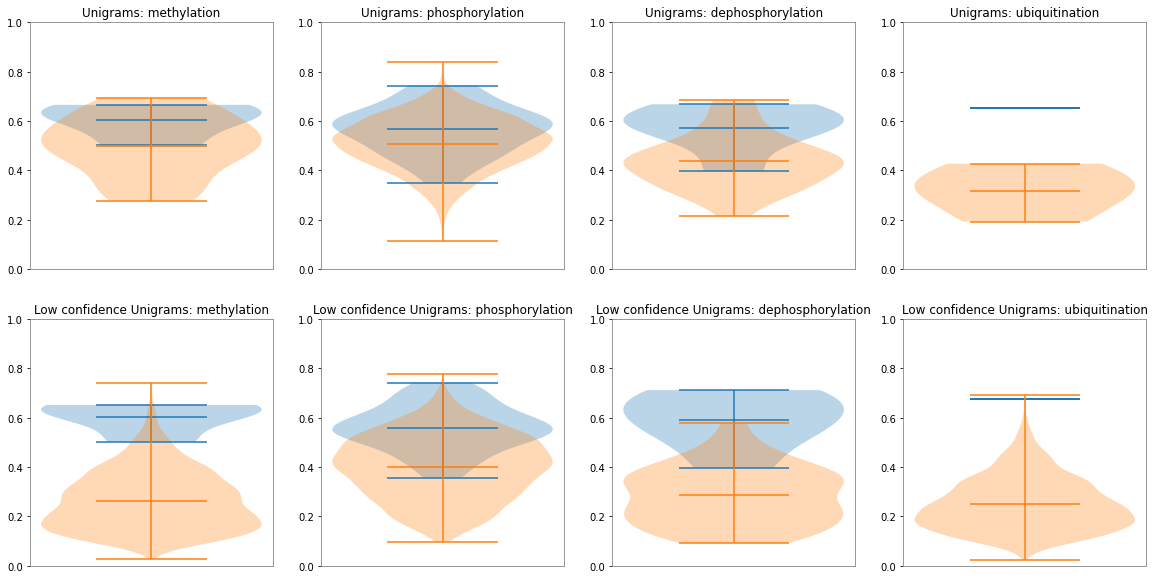

In [8]:
_,axes = plt.subplots(2,len(label_order), figsize=(20,10))



ax = axes[0]
plot_sim_scores(get_sim_scores(trainfile, testfile, n_gram=1), ax, label_order, "High confidence Unigrams:")


ax = axes[0]
plot_sim_scores(get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=1), 
                ax,label_order, "Unigrams:")

ax = axes[1]
plot_sim_scores(get_sim_scores(trainfile, testfile, n_gram=1), 
                ax,label_order, "Low confidence Unigrams:")
ax = axes[1]
plot_sim_scores(get_sim_scores(trainfile, predictions_below_threshold_file, n_gram=1), 
                ax,label_order, "Low confidence Unigrams:")


# ax = axes[1]
# plot_sim_scores(get_sim_scores(trainfile, testfile, n_gram=2), ax,label_order, "Bigrams:")


# ax = axes[1]
# plot_sim_scores(get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=2), ax, label_order, "Bigrams:")

plt.savefig(os.path.join(local_temp_wk_dir, "Largescalesimilarity.pdf"), bbox_inches="tight")

In [9]:
df = get_sim_scores(trainfile, predictions_above_threshold_file, n_gram=1)

df.groupby("interaction_type").describe()

best_score                                          \
                       count      mean       std       min       25%   
interaction_type                                                       
acetylation              1.0  0.253824       NaN  0.253824  0.253824   
dephosphorylation       29.0  0.435450  0.114593  0.215810  0.358989   
methylation             20.0  0.513932  0.122782  0.306547  0.441594   
phosphorylation       5656.0  0.509088  0.106048  0.109502  0.440913   
ubiquitination           4.0  0.318927  0.091991  0.201744  0.281712   

                                                 
                        50%       75%       max  
interaction_type                                 
acetylation        0.253824  0.253824  0.253824  
dephosphorylation  0.441950  0.472434  0.685753  
methylation        0.513482  0.625860  0.729271  
phosphorylation    0.516131  0.585666  0.840658  
ubiquitination     0.325014  0.362229  0.423936

In [10]:
df.head()

,best_score,best_match,interaction_type
0,0.253824,The regulation of gene repression by corepress...,acetylation
0,0.729271,Arginine methylation is a common post-translat...,methylation
1,0.626945,Arginine methylation is a common post-translat...,methylation
2,0.675351,Arginine methylation is a common post-translat...,methylation
3,0.504103,The mechanism underlying the protein-protein i...,methylation


In [11]:
df.interaction_type.value_counts()

phosphorylation      5656
dephosphorylation      29
methylation            20
ubiquitination          4
acetylation             1
Name: interaction_type, dtype: int64

## Top Words

In [12]:
 def transform_word_count(word_counts, word_indices):
            return {word_indices[i]: c for i, c in enumerate(word_counts) if c > 0}


In [38]:
from utils.top_words_similarity_comparer import TopWordsSimilarityComparer

def get_top_words(trainfile, test, n_gram):
    comparer =  PpiMulticlassComparer(comparer = TopWordsSimilarityComparer(n_gram=n_gram))
    comparison_result = comparer.compare(trainfile, test)
    
    result = []
    for interaction, (ref_words, test_words, word_indices) in comparison_result.items():
        df = pd.DataFrame({'test_words': test_words, 'ref_words': ref_words, 'interaction_type': [interaction]*len(ref_words), "word":[ word_indices[i] for i in range(len(ref_words))] })
        result.append(df)
    
    return pd.concat(result)


# def get_processed_abstracts(trainfile):
#     comparer =  PpiMulticlassComparer(comparer = lambda x,y: (x,y))
#     comparison_result = comparer.compare(trainfile, trainfile)
    
#     result = []
#     for interaction, (abstracts, _) in comparison_result.items():
#         df = pd.DataFrame({ 'abstract': abstracts, 'interaction_type': [interaction]*len(abstracts) })
#         result.append(df)
    
#     return pd.concat(result)



df_largescale_above_threshold = get_top_words(trainfile, predictions_above_threshold_file, n_gram=1)
df_largescale_below_threshold = get_top_words(trainfile, predictions_below_threshold_file, n_gram=1)
df_test = get_top_words(trainfile, testfile, n_gram=1)


In [53]:
from wordcloud import WordCloud
import numpy as np

def plot_wordcloud(word_frequency_dict, ax, title):
    # make 
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    
    wc = WordCloud(background_color="white",mask=mask, max_words=30, contour_width=3, contour_color='steelblue')

   
        
    # generate word cloud
    wc.generate_from_frequencies(word_frequency_dict)
    ngram=1
    ax.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)
    


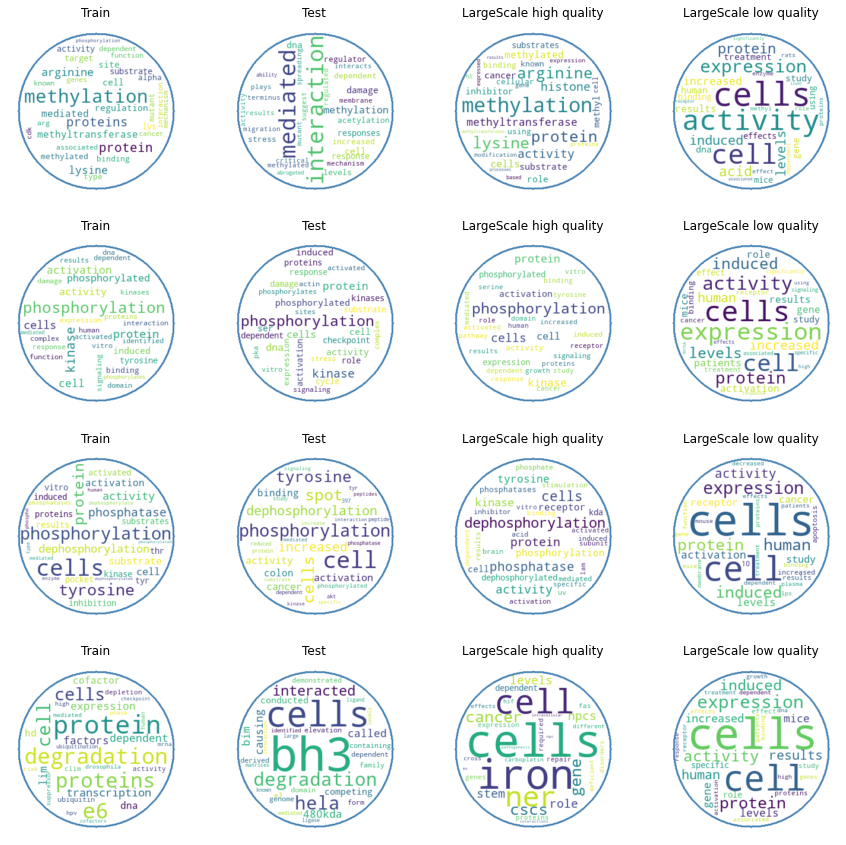

In [61]:
def prep_plot(df, word_col, freq_col, interaction, ignore={"protpart0", "protpart1","prtig0", "prtig1", "prtig2","prtig3"}):
    df = df.query(f"interaction_type == '{interaction}'")
    word_freq = dict(zip(df[word_col], df[freq_col]))
    for w in list(ignore):
        if w in word_freq:
            word_freq.pop(w)
    return word_freq

def plot_per_interaction_word_cloud():
    _, axes = plt.subplots(len(label_order),4, figsize=(15,15))
    
    for i,l in enumerate(label_order):

        ax=axes[i][0]                
        plot_wordcloud( prep_plot(df_test,"word", "ref_words", l), ax, "Train" )

        ax=axes[i][1]                  
        plot_wordcloud( prep_plot(df_test,"word", "test_words",  l), ax, "Test" )

        ax=axes[i][2]                 
        plot_wordcloud( prep_plot(df_largescale_above_threshold,"word", "test_words",  l), ax, "LargeScale high quality" )

        ax=axes[i][3]                
        plot_wordcloud( prep_plot(df_largescale_below_threshold,"word", "test_words",  l), ax, "LargeScale low quality" )
        
plot_per_interaction_word_cloud()

In [63]:
df_largescale_above_threshold.query("interaction_type == 'dephosphorylation'").sort_values(by='test_words').tail(n=30)

,test_words,ref_words,interaction_type,word
1502,13,5,dephosphorylation,specific
250,13,7,dephosphorylation,binding
482,13,9,dephosphorylation,dependent
1714,14,19,dephosphorylation,vitro
978,14,14,dephosphorylation,mediated
271,14,0,dephosphorylation,brain
1526,14,11,dephosphorylation,stimulation
124,15,5,dephosphorylation,acid
812,15,18,dephosphorylation,induced
1168,15,0,dephosphorylation,phosphate
